## Assume the Ref is not such intense as Qice cuz the Dice is not so big in TURB. So compare the QICE, REF, DICE
- Also wants to make sure if the rim ice influence the conclution so compare the QRIM.(Which is QIR in microphysics scheme =50)

In [2]:
import math

import numpy as np
from cartopy import crs
from cartopy.feature import COLORS, NaturalEarthFeature
from matplotlib import pyplot
from matplotlib.cm import get_cmap
from matplotlib.colors import from_levels_and_colors
from netCDF4 import Dataset
from scipy.interpolate import griddata
from wrf import (
    CoordPair,
    cartopy_xlim,
    cartopy_ylim,
    get_cartopy,
    getvar,
    interpline,
    latlon_coords,
    to_np,
    vertcross,
)

In [6]:
##function def part
#cross_start = CoordPair(lat=41.2, lon=-106.56)
#cross_end = CoordPair(lat=41.4, lon=-105.97)
cross_start = CoordPair(lat=41.16, lon=-107.21)
cross_end = CoordPair(lat=41.36, lon=-106.96)
###getvar from wrf files
def get(wrf_file,times):
    u = getvar(wrf_file, "ua",  timeidx = times)
    v = getvar(wrf_file, "va", timeidx = times)
    w = getvar(wrf_file, "wa", timeidx = times)
    ht = getvar(wrf_file, "z", timeidx=times)
    ter = getvar(wrf_file, "ter", timeidx=times)
    dbz = getvar(wrf_file, "REFL_10CM", timeidx=times)
    dbz = 10**(dbz/10)
    vice = getvar(wrf_file, "V_ICE", timeidx=times)
    qccol = getvar(wrf_file, "NCCOL", timeidx=times)
    qice = getvar(wrf_file, "NINUC", timeidx=times)
    qcloud = getvar(wrf_file, "QCLOUD", timeidx=times)*1000
    qrim = getvar(wrf_file, "QIR", timeidx=times)*1000
    qdep = getvar(wrf_file, "QIDEP", timeidx=times)*3600000
    return u, v, w, ht, ter, dbz, vice, qccol, qice, qcloud, qrim, qdep
## let the values under filled shape disappeared.
def cross(x,des,uni):
  #  X = 10**(x/10)
    x_cross = vertcross(x, ht, wrfin=wrf_file_c,start_point=cross_start,end_point=cross_end,latlon=True,meta=True)
    x1_cross = x_cross#10.0 * np.log10(x_cross)
    x1_cross.attrs.update(x_cross.attrs)
    x1_cross.attrs["description"] = des
    x1_cross.attrs["units"] = uni
    x_cross_filled = np.ma.copy(to_np(x1_cross))
    for i in range(x_cross_filled.shape[-1]):
        column_vals = x_cross_filled[:,i]
        # Let's find the lowest index that isn't filled. The nonzero function
        # finds all unmasked values greater than 0. Since 0 is a valid value
        # for dBZ, let's change that threshold to be -200 dBZ instead.
        first_idx = int(np.transpose((column_vals > -200).nonzero())[0])
        x_cross_filled[0:first_idx, i] = 0
    return x_cross_filled,x1_cross
##Calculate the relative diff
def diff(c, t):
    acc_percent = np.empty(shape = np.shape(c))
    acc_percent[:, :] = t[:, :]-c[:, :]
    acc_percent[np.isinf(acc_percent)]=0
    acc_percent = np.nan_to_num(acc_percent)
    return acc_percent

<xarray.DataArray 'NCCOL' ()>
array(2133819.)
Coordinates:
    XTIME    float32 540.0
    Time     datetime64[ns] 2006-01-18T21:00:00


/glade/u/ssg/ch/usr/jupyterhub/envs/npl-3.7.9/cheyenne/lib/python3.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in greater


709.4786
saving1821UTC...


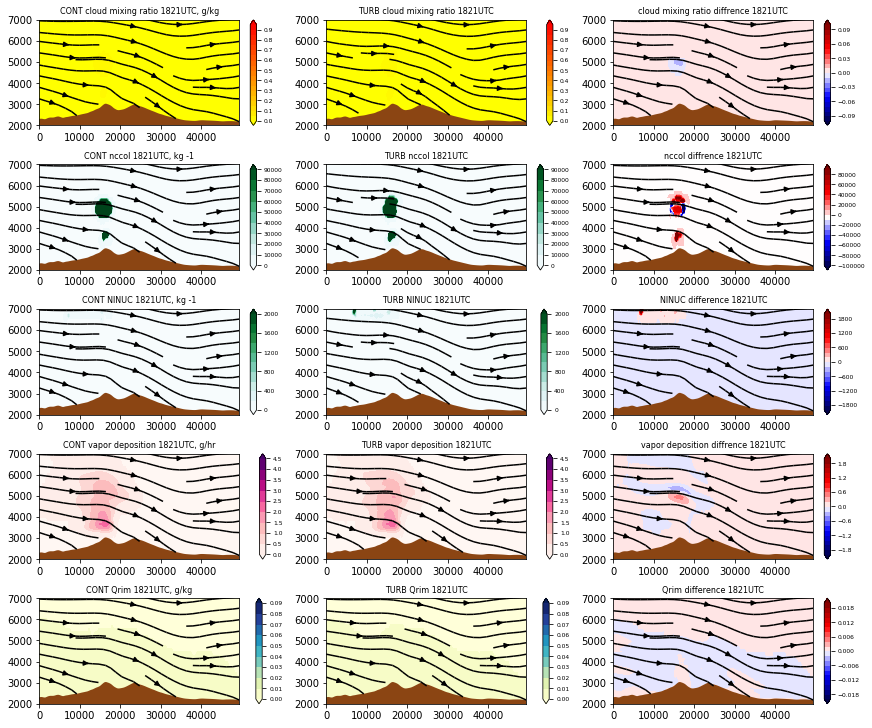

In [9]:
## i is the index of date, change to 18, 19 means change to date 18.
for i in range(18, 19):
    for j in range(9,10):
        if i==18:
            times_t = j
            times_c = j
            timeout = j+12
        elif i==19:
            times_t = j
            times_c = j
            timeout = j
       #wrf_file_t = Dataset("/glade/scratch/mingzhu/High_res/WRF/300out_turb_sierra/wrfout_d03_2006-01-18_12:00:00")
       #wrf_file_c = Dataset("/glade/scratch/mingzhu/High_res/WRF/300out_cont_sierra/wrfout_d03_2006-01-18_12:00:00")
        wrf_file_t = Dataset("/glade/scratch/mingzhu/High_res/WRF_test/run_sysu_turb/wrfout_d03_2006-01-18_12:00:00")
        wrf_file_c = Dataset("/glade/scratch/mingzhu/High_res/WRF_test/run_sysu_cont/wrfout_d03_2006-01-18_12:00:00")
        angle = math.radians(14)
        u, v, w, ht, ter, dbz, vice, qccol, qice, qcloud, qrim, qdep = get(wrf_file_c,times_c)
        u_t, v_t, w_t, ht_t, ter_t,dbz_t, vice_t, qccol_t, qice_t, qcloud_t, qrim_t, qdep_t = get(wrf_file_t,times_t)
        print(np.max(qccol))
        ####for define the CONT value's unit and description#####
        dbz,dbz1 = cross(dbz,'reflectivity', 'dBZ')
        ua = cross(u,'U-wind', 'm/s')[0]
        va = cross(v,'V-wind', 'm/s')[0]
        wa = cross(w,'W-wind', 'm/s')[0]
        vice = cross(vice, 'Vice', 'm/s')[0]
        qccol = cross(qccol,'ice number concentration','kg -1')[0]
        qice = cross(qice,'Ice mixing ratio','kg kg-1')[0]
        qcloud = cross(qcloud,'cloud water mixing ratio','m')[0]
        qrim = cross(qrim,'Rime ice mass-1 mixing ratio','kg kg(-1)')[0]
        qdep = cross(qdep, 'vapor deposition', 'g/s')[0]
        ####for define the TURB value's unit and description#####
        dbz_t,dbz1_t = cross(dbz_t,'reflectivity', 'dBZ')
        ua_t = cross(u_t,'U-wind', 'm/s')[0]
        va_t = cross(v_t,'V-wind', 'm/s')[0]
        wa_t = cross(w_t,'W-wind', 'm/s')[0]
        vice_t = cross(vice_t, 'Vice', 'm/s')[0]
        qccol_t = cross(qccol_t,'ice number concentration','kg -1')[0]
        qice_t = cross(qice_t,'Ice mixing ratio','kg kg-1')[0]
        qcloud_t = cross(qcloud_t,'cloud water mixing ratio','m')[0]
        qrim_t = cross(qrim_t,'Rime ice mass-1 mixing ratio','kg kg(-1)')[0]
        qdep_t = cross(qdep_t, 'vapor deposition', 'g/s')[0]
        ####for calculate the doppler velocity and stream line##
        #the cross_section is not parralell to the x-axis, so the stream line should
        #multiplied by angle between cross_section and x-axis
        dopp = to_np(wa-vice)
        hori = ua * math.cos(angle)
        stream = to_np(ua * math.cos(angle) + va * math.sin(angle))
        dopp_t = to_np(wa_t-vice_t)
        hori_t = ua_t * math.cos(angle)
        stream_t = to_np(ua_t * math.cos(angle) + va_t * math.sin(angle))
        #####For calculate the relative difference##############
        dbz_diff = diff(dbz, dbz_t)
        dopp_diff = diff(dopp, dopp_t)
        hori_diff = diff(hori,hori_t)
        qccol_diff = diff(qccol, qccol_t)
        qice_diff = diff(qice, qice_t)
        qcloud_diff = diff(qcloud, qcloud_t)
        qrim_diff = diff(qrim, qrim_t)
        qdep_diff = diff(qdep, qdep_t)
        #####draw the terrain shape#############################
        ter_line = interpline(ter, wrfin=wrf_file_c, start_point=cross_start,
                      end_point=cross_end)
        lats, lons = latlon_coords(u)#x, y coord
        cart_proj = get_cartopy(u)#import the project from wrf value
        ###creat the figure##################################3
        fig, ((ax_cloud,ax_cloud_t,ax_cloud_diff)#qcloud
             ,(ax_ccol, ax_ccol_t, ax_ccol_diff)#qccol
             ,(ax_q, ax_q_t, ax_q_diff)#QICE
             ,(ax_d, ax_d_t, ax_d_diff)#DEp
             ,(ax_r, ax_r_t, ax_r_diff)#QRIM
             ) = pyplot.subplots(5,3,figsize=(12,10),constrained_layout=True)
        xs = np.arange(0, dbz1.shape[-1], 1)*300
        ys = to_np(dbz1.coords["vertical"])
    
        def crossplot(cname, x, y, z, hori, ver, levels, colors, title):
                      var_fill = cname.contourf(x,y,z, levels = levels, cmap=get_cmap(colors), extend = 'both')
                      ht_fill = cname.fill_between(x, 0, to_np(ter_line),facecolor="saddlebrown")
                      cname.set_ylim([0, 7000])
                      cname.set_title(title, fontsize=8)
                      cb_cross = fig.colorbar(var_fill, ax=cname)
                      cb_cross.ax.tick_params(labelsize=6)
                      s1 = cname.streamplot(to_np(x), to_np(y),
                                            hori,
                                            ver,
                                            color = 'k')
                      cname.set_ylim([2000, 7000])
                    
        ####### CALL cross plot function for every var of CONT###############
        print(np.max(qice))
        crossplot(ax_cloud,xs,ys,qcloud,stream,dopp,np.arange(0., 1, .05),"autumn_r",'CONT cloud mixing ratio %02d' % (i) + '%02d' % (timeout) + 'UTC, g/kg')
        crossplot(ax_ccol,xs,ys,qccol,stream,dopp,np.arange(0,1e5,1e4),"BuGn",'CONT nccol %02d' % (i) + '%02d' % (timeout) + 'UTC, kg -1')
        crossplot(ax_q,xs,ys,qice,stream,dopp,np.arange(0,2200,200),"BuGn",'CONT NINUC %02d' % (i) + '%02d' % (timeout) + 'UTC, kg -1')
        crossplot(ax_d,xs,ys,qdep,stream,dopp,np.arange(0,5,.5),"RdPu",'CONT vapor deposition %02d' % (i) + '%02d' % (timeout) + 'UTC, g/hr')
        crossplot(ax_r,xs,ys,qrim,stream,dopp,np.arange(0,.1,.01),"YlGnBu",'CONT Qrim %02d' % (i) + '%02d' % (timeout) + 'UTC, g/kg')

        #
        crossplot(ax_cloud_t,xs,ys,qcloud_t,stream,dopp_t,np.arange(0., 1, .05),"autumn_r",'TURB cloud mixing ratio %02d' % (i) + '%02d' % (timeout) + 'UTC')   
        crossplot(ax_ccol_t,xs,ys,qccol_t,stream,dopp_t,np.arange(0,1e5,1e4),"BuGn",'TURB nccol %02d' % (i) + '%02d' % (timeout) + 'UTC')
        crossplot(ax_q_t,xs,ys,qice_t,stream,dopp_t,np.arange(0,2200,200),"BuGn",'TURB NINUC %02d' % (i) + '%02d' % (timeout) + 'UTC')
        crossplot(ax_d_t,xs,ys,qdep_t,stream,dopp,np.arange(0,5,.5),"RdPu",'TURB vapor deposition %02d' % (i) + '%02d' % (timeout) + 'UTC')
        crossplot(ax_r_t,xs,ys,qrim_t,stream,dopp,np.arange(0,.1,.01),"YlGnBu",'TURB Qrim %02d' % (i) + '%02d' % (timeout) + 'UTC')
        
        #
        acclevel = np.arange(-1, 1, .05)
        crossplot(ax_cloud_diff,xs,ys,qcloud_diff,stream,dopp,np.arange(-0.1, .11, .01),"seismic",'cloud mixing ratio diffrence %02d' % (i) + '%02d' % (timeout) + 'UTC')
        crossplot(ax_ccol_diff,xs,ys,qccol_diff,stream,dopp,np.arange(-1e5, 1e5,1e4),"seismic",'nccol diffrence %02d' % (i) + '%02d' % (timeout) + 'UTC')
        crossplot(ax_q_diff,xs,ys,qice_diff,stream,dopp,np.arange(-2000,2200,200),"seismic",'NINUC difference %02d' % (i) + '%02d' % (timeout) + 'UTC')
        crossplot(ax_d_diff,xs,ys,qdep_diff,stream,dopp,np.arange(-2, 2.2, .2),"seismic",'vapor deposition diffrence %02d' % (i) + '%02d' % (timeout) + 'UTC')
        crossplot(ax_r_diff,xs,ys,qrim_diff,stream,dopp,np.arange(-.02, .022, .002),"seismic",'Qrim difference %02d' % (i) + '%02d' % (timeout) + 'UTC')
        
        
        print('saving%02d' % (i) + '%02d' % (timeout) + 'UTC...')
        #pyplot.savefig('cross_sec/ABS_YSUmed_comparediff_ref_ice%02d'% (i) + '%02d' % (timeout) + '.png', facecolor = 'w')
        #pyplot.savefig('1900_fixref.png', facecolor = 'w')